In [ ]:
# !pip3 install git+https://github.com/deepmind/dm-haiku
# !pip3 install git+https://github.com/jax-ml/oryx.git
# !pip3 install --upgrade jax jaxlib chex
# !pip install --upgrade git+https://github.com/deepmind/optax.git
!pip3 install dm-haiku==0.0.12
!pip3 install jmp==0.0.4
!pip3 install oryx==0.2.6
# !pip3 install tensorflow-probability==0.19.0
!pip3 install jax==0.4.25
!pip3 install jaxlib==0.4.25
!pip3 install chex==0.1.85
# !pip3 install numpy==1.25.1
!pip install optax==0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.9/204.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: chex
    Found existing installation: chex 0.1.86
    Uninstalling chex-0.1.86:
      Successfully uninstalled chex-0.1.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

In [ ]:
from functools import partial
from typing import Callable

import jax
from jax import random, vmap
import jax.numpy as jnp
import jax.scipy as jsp
import haiku as hk
import optax
from oryx.core import inverse_and_ildj
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt

In [ ]:
n_samples = 2000
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05, random_state=42)
X, y = datasets.make_blobs(
        n_samples = n_samples,
        n_features = 2,
        centers = 5,
        cluster_std = 1,
        shuffle = True,
        random_state = 9)
X = StandardScaler().fit_transform(X)

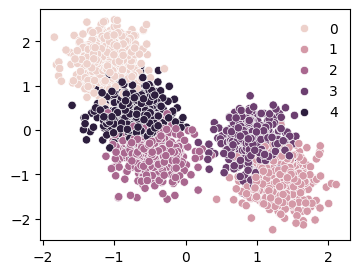

In [ ]:
plt.figure(figsize=(4,3))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
# plt.axis('off')
plt.legend(frameon=False)

In essence, normalising flows are functions $f(\pmb{z})=\pmb{x}$ with an inverse. The idea is to let $\pmb{z}$ be a latent representation corresponding to a sample $\pmb{x}$. The strategy is then to choose a distribution $p(\pmb{z})$ that is easy to sample from, and then find a $f$ that gives you realistic samples $\pmb{x}$ (e.g., images from a cat). Linear transformations are  simple, but as we'Il see, surprisingly powerful. For RealNVP in particular, we use the following set of transformations:
$$
\pmb{x}_1 = \pmb{z}_1;\\
\pmb{x}_2 = \pmb{z}_2 \odot e^s + \pmb{t}  
$$

In [ ]:
class Affine(hk.Module):
  """A shift and scale layer."""
  def __init__(self, flip: bool = False):
    super().__init__()
    self.flip = flip  # Permute lower and upper blocks.

  def __call__(self, z):
    """Do affine transformation on lower block."""
    z_1, z_2 = jnp.split(z, 2)
    if self.flip:
      z_1, z_2 = z_2, z_1

    # Predict shift and scale parameters using neural network.
    n_features = z.shape[-1]
    neural_net = hk.nets.MLP(output_sizes=[512, 128, n_features])
    shift_scale = neural_net(z_1)
    shift, scale = jnp.split(shift_scale, 2, axis=-1)

    # Apply shift and scale transformation to lower block.
    x_1 = z_1
    x_2 = z_2 * jnp.exp(scale) + shift
    return jnp.concatenate([x_1, x_2])

In [ ]:
@hk.without_apply_rng
@hk.transform
def forward(z):
  flow = hk.Sequential(layers=[
      Affine(),
      Affine(flip=True),
      Affine(),
      Affine(flip=True),
  ])
  return flow(z)

In [ ]:
# Make f(z) invertible by combining params and forward.apply.
f_inv_and_ildj = inverse_and_ildj(lambda p, z: [p, forward.apply(p, z)])

@partial(vmap, in_axes=[None, 0])
def log_prob(params, x):
  """Log-likelihood of a single example x."""
  # Compute: z = f⁻¹(x) and ln |det ∂f⁻¹/∂x|.
  (_, z), inv_log_det_jac = f_inv_and_ildj(params, x)
  logp_z = jsp.stats.norm.logpdf(z)
  logp_x = logp_z.sum() + inv_log_det_jac
  return logp_x

def loss(params, x_batch):
  """Negative log likelihood: ℒ = 1/m ∑ ln p(xᵢ)."""
  return -jnp.mean(log_prob(params, x_batch))

In [ ]:
# Random key iterator.
key_seq = hk.PRNGSequence(42)

# Initialise parameters of flow network.
n_features = 2
z_forward = random.normal(next(key_seq), shape=[n_features])
params = forward.init(next(key_seq), z_forward)

In [ ]:
# Compute loss and gradients in one go and make it snappy with jit.
loss_and_grad = jax.jit(jax.value_and_grad(loss))

# Initialise optimiser.
optimizer = optax.adam(learning_rate=5e-4)
opt_state = optimizer.init(params)

In [ ]:
for i in range(10_000):
  x_batch = X[jax.random.choice(next(key_seq), X.shape[0], [256])]
  neg_log_likel, grads = loss_and_grad(params, x_batch)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if i % 1000 == 0:
    print(f'{i}: Loss', neg_log_likel)

0: Loss 3.0700943
1000: Loss 2.059001
2000: Loss 1.9725685
3000: Loss 1.9993424
4000: Loss 1.9417849
5000: Loss 1.8970859
6000: Loss 1.9827654
7000: Loss 2.0581355
8000: Loss 1.9231622
9000: Loss 1.9518559


In [ ]:
# Generate a 1k examples for visualisation.
m_samples = 20000
z_forward1 = random.normal(next(key_seq), shape=[m_samples, n_features])
forward_batched = vmap(forward.apply, in_axes=[None, 0])
data_x = forward_batched(params, z_forward1)

In [ ]:
# Generate a 1k examples for visualisation.
m_samples = 20000
# z_forward = random.normal(next(key_seq), shape=[m_samples, n_features])
forward_batched = vmap(forward.apply, in_axes=[None, 0])
data_y = forward_batched(params, z_forward1)

In [ ]:
# Generate a 1k examples for visualisation.
m_samples = 100000
# z_forward = random.normal(next(key_seq), shape=[m_samples, n_features])
forward_batched = vmap(forward.apply, in_axes=[None, 0])
data_y_circ = forward_batched(params, z_forward1)

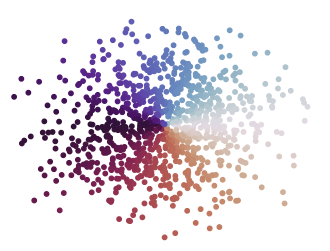

In [ ]:
import numpy as np
from matplotlib import animation, rc

@hk.without_apply_rng
@hk.transform
def partial_forward(z, n_layers):
  """Apply a subset of the entire flow."""
  flow = hk.Sequential(layers=[
      Affine(flip=bool(i % 2))
      for i in range(n_layers)
  ])
  return flow(z)

partial_forward_batched = vmap(partial_forward.apply, in_axes=[None, 0, None])

# Compute intermediate values of sequential flow.
values = [z_forward1[:1000]]
for i in range(1, 5):
  x_partial = partial_forward_batched(params, z_forward1[:1000], i)
  values.append(x_partial)

# Animate intermediate values of normalising flow.
fig, ax = plt.subplots(figsize=(4, 3))
xlim, ylim = [-3, 3], [-3, 3]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axis('off')

angles = np.arctan2(z_forward1[:1000, 1], z_forward1[:1000, 0])
angles = angles % (2 * np.pi)
angles_normalized = angles / (2 * np.pi)

y = values[0]
paths = ax.scatter(y[:, 0], y[:, 1], s=10, c=angles_normalized, cmap='twilight')
frames = [values[0], *values, values[-1]]

def interpolate_frames(i):
  l = i//48
  t = (float(i%48))/48
  y = (1-t)*frames[l] + t*frames[l+1]
  paths.set_offsets(y)
  return (paths,)

anim = animation.FuncAnimation(fig, interpolate_frames, frames=48*6, interval=1, blit=False)
anim.save('gradual_flow.gif', writer='imagemagick', fps=48)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output

In [ ]:
data_x1 = np.array(data_x[:11000])
# epsilons = np.random.normal(loc=0.0, scale=0.1, size=data_x.shape)
# data_x1[:, 0] = data_x1[:, 0] / 2
data_x2 = Normalizer().fit_transform(data_x1)
# data_x1 = StandardScaler().fit_transform(data_x1)
# data_x1 = (data_x1 + epsilons).astype(np.float32)
# for i in range(len(data_x1)):
#     if np.random.randint(33) == 32:
#         temp = data_x1[i]
#         ind = np.random.randint(len(data_x1))
#         data_x1[i] = data_x1[ind]
#         data_x1[ind] = temp
        # data_x1[i] = forward_batched(params, np.array([np.random.rand(2)]))

data_y1 = np.array(data_y[:11000])
data_y2 = Normalizer().fit_transform(data_y1)
# data_y1 = StandardScaler().fit_transform(data_y1)
# epsilons = np.random.normal(loc=0.0, scale=0.1, size=data_x.shape)
# data_y1 = (data_y1 + epsilons).astype(np.float32)

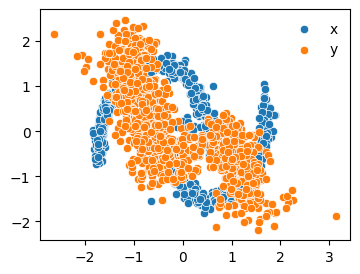

In [ ]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x=data_x1[:1000, 0], y=data_x1[:1000, 1], label='x')
sns.scatterplot(x=data_y1[:1000, 0], y=data_y1[:1000, 1], label='y')
plt.legend(frameon=False)

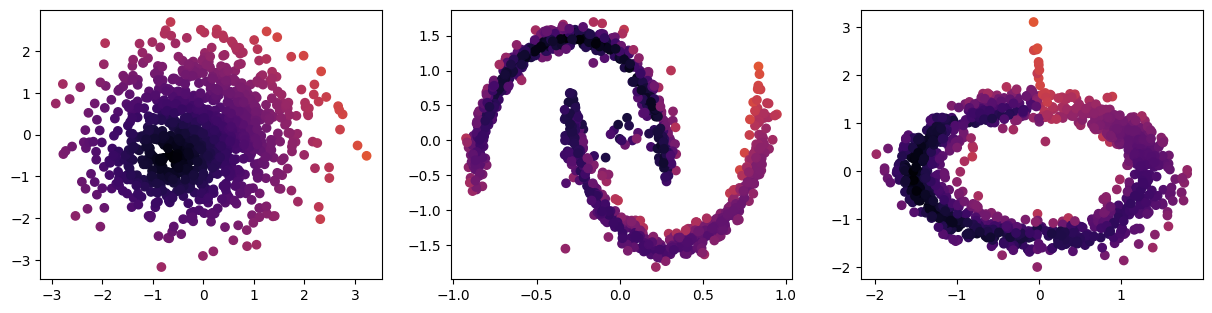

In [ ]:
dist_matrix = np.linalg.norm(z_forward1[:1000, None] - z_forward1[:1000], axis=2)
normalized_dist_matrix = (dist_matrix - dist_matrix.min()) / (dist_matrix.max() - dist_matrix.min())
colors = plt.cm.inferno(normalized_dist_matrix)

fig, axs = plt.subplots(1, 3, figsize=(15, 3.5))
axs[0].scatter(z_forward1[:1000, 0], z_forward1[:1000, 1], c=colors[0])
axs[1].scatter(data_x1[:1000, 0], data_x1[:1000, 1], c=colors[0])
axs[2].scatter(data_y1[:1000, 0], data_y1[:1000, 1], c=colors[0])

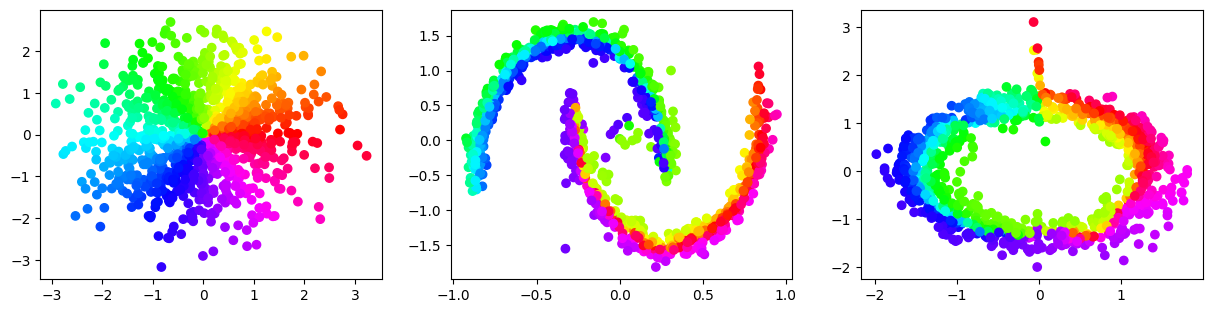

In [ ]:
angles = np.arctan2(z_forward1[:1000, 1], z_forward1[:1000, 0])
angles = angles % (2 * np.pi)
angles_normalized = angles / (2 * np.pi)

fig, axs = plt.subplots(1, 3, figsize=(15, 3.5))
axs[0].scatter(z_forward1[:1000, 0], z_forward1[:1000, 1], c=angles_normalized, cmap='hsv')
axs[1].scatter(data_x1[:1000, 0], data_x1[:1000, 1], c=angles_normalized, cmap='hsv')
axs[2].scatter(data_y1[:1000, 0], data_y1[:1000, 1], c=angles_normalized, cmap='hsv')

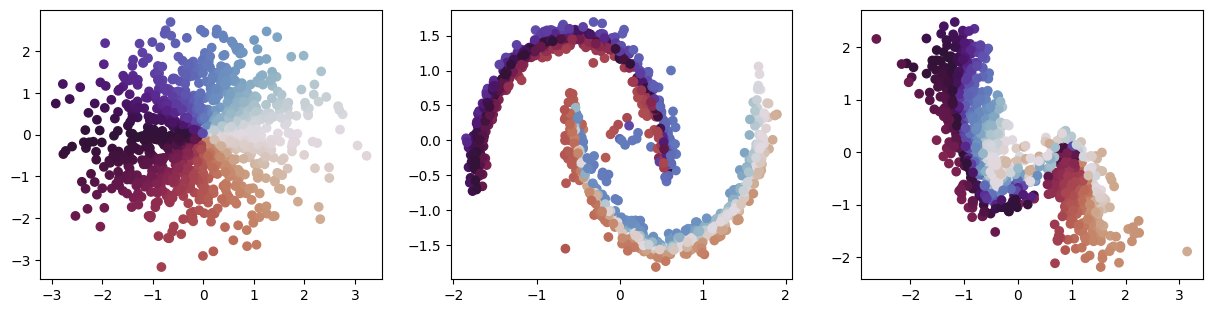

In [ ]:
angles = np.arctan2(z_forward1[:1000, 1], z_forward1[:1000, 0])
angles = angles % (2 * np.pi)
angles_normalized = angles / (2 * np.pi)

fig, axs = plt.subplots(1, 3, figsize=(15, 3.5))
axs[0].scatter(z_forward1[:1000, 0], z_forward1[:1000, 1], c=angles_normalized, cmap='twilight')
axs[1].scatter(data_x1[:1000, 0], data_x1[:1000, 1], c=angles_normalized, cmap='twilight')
axs[2].scatter(data_y1[:1000, 0], data_y1[:1000, 1], c=angles_normalized, cmap='twilight')

In [ ]:
distances = np.linalg.norm(data_x1[:1000] - data_y1[:1000], axis=1)
average_distance = np.mean(distances)
print("MAE:", average_distance)

MAE: 1.5084363


In [ ]:
class train_dataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, index):
        return self.data_x[index], self.data_y[index]

In [ ]:
def get_negative_mask(batch_size):
    """
    Шаблон для маски с нулями на главной диагонали и на двух
    параллельных ей
    """
    negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0

    negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask

def get_target_mask(target: torch.Tensor) -> torch.Tensor:
    """
    Generate bool matrix for equal targets
    """
    target_ = torch.cat([target, target], dim=0).view(-1, 1)  # (2bs,)
    mask = (target_ == target_.t().contiguous()) & (target_ != -1)  # (2bs, 2bs)
    return mask


def replace_pos_diagonals(full_matrix, pos_m):
    """
    Replace positive sub-diagonals in full_matrix shaped (2bs, 2bs) by pos_m vector
    """
    batch_size = full_matrix.shape[0] // 2

    new_matrix = full_matrix.clone()

    new_matrix[range(batch_size), range(batch_size, 2*batch_size)] = pos_m[:batch_size]
    new_matrix[range(batch_size, 2*batch_size), range(batch_size)] = pos_m[batch_size:]
    return new_matrix

class ContrastiveLossBase(nn.Module):
    def __init__(self, temperature=1., cuda=False):
        super().__init__()
        self.temperature: float = temperature
        self.cuda: bool = cuda

    def forward(self, out_1, out_2):
        batch_size = out_1.shape[0]

        out = torch.cat([out_1, out_2], dim=0)
        # Скалярное произведение
        full = torch.exp(torch.mm(out, out.t().contiguous()) / self.temperature)

        # Негативные пары
        mask = get_negative_mask(batch_size)
        if self.cuda:
            mask = mask.cuda()
        neg = full.masked_select(mask).view(2 * batch_size, -1)

        # Скалярное произведение двух позитивных элементов
        pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / self.temperature)
        pos = torch.cat([pos, pos], dim=0)

        return pos, neg

class ContrastiveLoss(ContrastiveLossBase):
    def forward(self, out_1, out_2):
        pos, neg = super().forward(out_1, out_2)
        Ng = neg.sum(dim=-1)
        loss = (-torch.log(pos / (pos + Ng))).mean()
        return loss

class DebiasedNegLoss(ContrastiveLossBase):
    def __init__(self, temperature=1., cuda=False, tau_plus = 0.1):
        super().__init__(temperature, cuda)
        self.tau_plus = tau_plus

    def forward(self, out_1, out_2):
        pos, neg = super().forward(out_1, out_2)
        batch_size = out_1.shape[0]

        N = batch_size * 2 - 2
        Ng = (-self.tau_plus * N * pos + neg.sum(dim=-1)) / (1 - self.tau_plus)
        # constrain (optional)
        Ng = torch.clamp(Ng, min=N * np.e ** (-1 / self.temperature))
        loss = (-torch.log(pos / (pos + Ng))).mean() # contrastive loss
        return loss

    def extra_repr(self):
        return "Tau plus: {}".format(self.tau_plus)


class DebiasedPosLoss(nn.Module):
    def __init__(self, temperature, cuda, tau_plus):
        super().__init__()
        self.temperature: float = temperature
        self.cuda: bool = cuda
        self.tau_plus: float = tau_plus

    def forward(self, out_1, out_2):
        batch_size = out_1.shape[0]
        N = batch_size * 2 - 2

        out = torch.cat([out_1, out_2], dim=0)
        # print(out.mean())
        full = torch.exp(torch.mm(out, out.t().contiguous()) / self.temperature)

        # Позитивные классы
        pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / self.temperature)
        pos = torch.cat([pos, pos], dim=0)

        full = replace_pos_diagonals(full, pos)
        p_estimate = full.mean(dim=-1)

        # Негативные классы
        neg_mask = get_negative_mask(batch_size)
        neg = full.masked_select(neg_mask).view(2 * batch_size, -1)

        # Вычисление лосс-функции
        tau_minus = 1 - self.tau_plus
        g = neg.mean(dim=-1)
        numerator = 1 - tau_minus * g / p_estimate
        denominator = 1 + (N * self.tau_plus - tau_minus) * g / p_estimate
        loss = (-torch.log(numerator / denominator)).mean()

        return loss


In [ ]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super(KLDivergenceLoss, self).__init__()

    def forward(self, model_output):
        # Assuming model_output is a batch of 2D vectors
        # Calculate the mean and variance of the batch
        batch_mean = torch.mean(model_output, dim=0)
        batch_var = torch.var(model_output, dim=0)

        # Standard normal distribution has mean=0 and variance=1
        # Calculate the KL Divergence
        kl_divergence = torch.log(batch_var) + (1 + batch_mean.pow(2)) / (2 * batch_var.pow(2)) - 0.5

        return kl_divergence

def kl_divergence_loss(batch):
    mean = torch.mean(batch, dim=0)
    variance = torch.var(batch, dim=0)

    # Стандартное нормальное распределение
    normal_dist = torch.distributions.Normal(torch.tensor([0.0, 0.0]), torch.tensor([1.0, 1.0]))

    # Вычисляем KL-дивергенцию между batch и стандартным нормальным распределением
    kl_div = torch.distributions.kl.kl_divergence(
        torch.distributions.Normal(mean, torch.sqrt(variance)),
        normal_dist
    )

    # Считаем среднее значение KL-дивергенции по батчу
    kl_div_loss = torch.mean(kl_div)

    return kl_div_loss

class GaussianRegularizer(nn.Module):
    def __init__(self, mu=0, sigma=1):
        super(GaussianRegularizer, self).__init__()
        self.mu = mu
        self.sigma = sigma

    def forward(self, x):
        loss = torch.mean((x - self.mu)**2 / (2*self.sigma**2))
        return loss

def normal_distribution_loss(fake_data):
    mu = torch.tensor([0.0, 0.0])
    sigma = torch.tensor([1.0, 1.0])
    normal_dist = torch.distributions.Normal(mu, sigma)
    log_prob = normal_dist.log_prob(fake_data)
    return -torch.mean(log_prob)

class NormalDistributionLoss(nn.Module):
    def __init__(self):
        super(NormalDistributionLoss, self).__init__()
        self.mu = torch.tensor([0.0, 0.0])
        self.sigma = torch.tensor([[1.0, 0.0], [0.0, 1.0]])

    def forward(self, x):
        det = torch.det(self.sigma)
        inv = torch.inverse(self.sigma)
        diff = x - self.mu
        exponent = torch.exp(-0.5 * torch.matmul(torch.matmul(diff, inv), diff.t()))
        prob = 1 / (2 * 3.14159265359 * det.sqrt()) * exponent
        loss = -torch.log(prob).mean()
        return loss

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1_x = nn.Linear(2, 10)
        # self.bn1_x = nn.BatchNorm1d(10)
        self.fc2_x = nn.Linear(10, 5)
        self.fc3_x = nn.Linear(5, 2)

        self.fc1_y = nn.Linear(2, 10)
        # self.bn1_y = nn.BatchNorm1d(10)
        self.fc2_y = nn.Linear(10, 7)
        self.fc3_y = nn.Linear(7, 2)

    def forward(self, x, y):
        x = self.fc1_x(x)
        x = F.relu(x)
        # x = F.relu(self.bn1_x(x))
        x = F.relu(self.fc2_x(x))
        x = self.fc3_x(x)

        y = self.fc1_y(y)
        y = F.relu(y)
        # y = F.relu(self.bn1_y(y))
        y = F.relu(self.fc2_y(y))
        y = self.fc3_y(y)

        return x, y

In [55]:
def train(net, loss_func, data_loader, train_optimizer, batch_size, *, cuda=False, step=0):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, data_loader
    total_contrastive_loss, total_normal_x_loss, total_normal_y_loss = 0.0, 0.0, 0.0
    # normal_x = KLDivergenceLoss()
    # normal_y = KLDivergenceLoss()
    for pos_1, pos_2 in train_bar:
        train_optimizer.zero_grad()
        x, y = net(pos_1, pos_2)
        x_norm = F.normalize(x, dim=1)
        y_norm = F.normalize(y, dim=1)

        contrastive_loss = 0.25 * loss_func(x_norm, y_norm)
        normal_x_loss = kl_divergence_loss(x)
        normal_y_loss = kl_divergence_loss(y)
        loss = contrastive_loss + normal_x_loss + normal_y_loss
        step += 1
        loss.backward()
        train_optimizer.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        total_contrastive_loss += contrastive_loss.item() * batch_size
        total_normal_x_loss += normal_x_loss.item() * batch_size
        total_normal_y_loss += normal_y_loss.item() * batch_size
    return total_loss / total_num, total_contrastive_loss / total_num, total_normal_x_loss / total_num, total_normal_y_loss / total_num, step

In [56]:
epochs = 200
batch_size = 16

angles_test = np.arctan2(z_forward1[10001:11000, 1], z_forward1[10001:11000, 0])
angles_test = angles_test % (2 * np.pi)
angles_test = angles_test / (2 * np.pi)

images = []

train_loader = DataLoader(
    train_dataset(data_x1[:10000], data_y1[:10000]),
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    pin_memory=True,
    drop_last=True,
)

encoder = Encoder()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)#, weight_decay=0.001)
loss_func = ContrastiveLoss(temperature=1., cuda=False)#, tau_plus=0.1)

# discriminator = Discriminator()
# discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

for epoch in tqdm(range(1, epochs + 1)):
    loss, c_loss, x_loss, y_loss, step = train(encoder, loss_func, train_loader, optimizer, batch_size)
    # loss, c_loss, x_loss, y_loss = train(encoder, discriminator, loss_func, train_loader, encoder_optimizer, discriminator_optimizer, batch_size)
    if (epoch - 1) % 5 == 0:
        # clear_output(wait=True)
        print(f"Epoch {epoch}, loss: {round(loss, 3)}, c_loss: {round(c_loss, 3)}, x_loss: {round(x_loss, 3)}, y_loss: {round(y_loss, 3)}")

    encoder.eval()
    x, y = encoder(torch.tensor(data_x1[10001:11000]), torch.tensor(np.array(data_y1[10001:11000])))
    out = torch.cat([x, y], dim=0).detach().numpy()
    out = np.array(out)

    plt.scatter(out[:, 0], out[:, 1], c=list(angles_test) * 2, cmap='twilight')
    # plt.xlim((-0.25, 0.25))
    # plt.ylim((-0.25, 0.25))

    filename = f"iteration_{epoch}.png"
    plt.savefig(filename)
    images.append(filename)

    plt.clf()

print(f"Epoch {epoch}, loss: {loss}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, loss: 2.048, c_loss: 0.901, x_loss: 0.375, y_loss: 0.771


  2%|▎         | 5/200 [00:24<14:28,  4.46s/it]

Epoch 6, loss: 0.906, c_loss: 0.815, x_loss: 0.044, y_loss: 0.047


  5%|▌         | 10/200 [00:44<12:25,  3.92s/it]

Epoch 11, loss: 0.883, c_loss: 0.781, x_loss: 0.048, y_loss: 0.053


  8%|▊         | 15/200 [01:05<12:46,  4.14s/it]

Epoch 16, loss: 0.849, c_loss: 0.753, x_loss: 0.044, y_loss: 0.053


 10%|█         | 20/200 [01:24<11:26,  3.82s/it]

Epoch 21, loss: 0.836, c_loss: 0.737, x_loss: 0.046, y_loss: 0.053


 12%|█▎        | 25/200 [01:45<12:33,  4.30s/it]

Epoch 26, loss: 0.826, c_loss: 0.727, x_loss: 0.047, y_loss: 0.052


 15%|█▌        | 30/200 [02:04<11:02,  3.90s/it]

Epoch 31, loss: 0.818, c_loss: 0.722, x_loss: 0.044, y_loss: 0.052


 18%|█▊        | 35/200 [02:26<11:40,  4.24s/it]

Epoch 36, loss: 0.814, c_loss: 0.72, x_loss: 0.045, y_loss: 0.049


 20%|██        | 40/200 [02:45<10:19,  3.87s/it]

Epoch 41, loss: 0.811, c_loss: 0.719, x_loss: 0.043, y_loss: 0.049


 22%|██▎       | 45/200 [03:05<10:34,  4.09s/it]

Epoch 46, loss: 0.816, c_loss: 0.717, x_loss: 0.047, y_loss: 0.051


 25%|██▌       | 50/200 [03:25<09:49,  3.93s/it]

Epoch 51, loss: 0.811, c_loss: 0.717, x_loss: 0.045, y_loss: 0.05


 28%|██▊       | 55/200 [03:46<09:54,  4.10s/it]

Epoch 56, loss: 0.808, c_loss: 0.716, x_loss: 0.044, y_loss: 0.049


 30%|███       | 60/200 [04:05<08:48,  3.77s/it]

Epoch 61, loss: 0.804, c_loss: 0.715, x_loss: 0.043, y_loss: 0.046


 32%|███▎      | 65/200 [04:25<09:08,  4.07s/it]

Epoch 66, loss: 0.811, c_loss: 0.714, x_loss: 0.045, y_loss: 0.051


 35%|███▌      | 70/200 [04:44<08:21,  3.86s/it]

Epoch 71, loss: 0.802, c_loss: 0.713, x_loss: 0.041, y_loss: 0.047


 38%|███▊      | 75/200 [05:04<08:33,  4.11s/it]

Epoch 76, loss: 0.803, c_loss: 0.713, x_loss: 0.043, y_loss: 0.047


 40%|████      | 80/200 [05:23<07:48,  3.91s/it]

Epoch 81, loss: 0.804, c_loss: 0.713, x_loss: 0.044, y_loss: 0.047


 42%|████▎     | 85/200 [05:42<07:10,  3.74s/it]

Epoch 86, loss: 0.799, c_loss: 0.71, x_loss: 0.042, y_loss: 0.047


 45%|████▌     | 90/200 [06:02<07:06,  3.88s/it]

Epoch 91, loss: 0.796, c_loss: 0.709, x_loss: 0.041, y_loss: 0.046


 48%|████▊     | 95/200 [06:21<06:42,  3.83s/it]

Epoch 96, loss: 0.804, c_loss: 0.71, x_loss: 0.046, y_loss: 0.048


 50%|█████     | 100/200 [06:43<06:52,  4.13s/it]

Epoch 101, loss: 0.799, c_loss: 0.71, x_loss: 0.043, y_loss: 0.047


 52%|█████▎    | 105/200 [07:02<06:10,  3.90s/it]

Epoch 106, loss: 0.792, c_loss: 0.709, x_loss: 0.04, y_loss: 0.043


 55%|█████▌    | 110/200 [07:22<06:07,  4.08s/it]

Epoch 111, loss: 0.792, c_loss: 0.709, x_loss: 0.04, y_loss: 0.044


 57%|█████▊    | 115/200 [07:42<05:27,  3.86s/it]

Epoch 116, loss: 0.804, c_loss: 0.71, x_loss: 0.045, y_loss: 0.048


 60%|██████    | 120/200 [08:02<05:26,  4.08s/it]

Epoch 121, loss: 0.799, c_loss: 0.709, x_loss: 0.044, y_loss: 0.046


 62%|██████▎   | 125/200 [08:21<04:48,  3.84s/it]

Epoch 126, loss: 0.794, c_loss: 0.709, x_loss: 0.042, y_loss: 0.043


 65%|██████▌   | 130/200 [08:41<04:38,  3.97s/it]

Epoch 131, loss: 0.803, c_loss: 0.709, x_loss: 0.046, y_loss: 0.048


 68%|██████▊   | 135/200 [09:01<04:17,  3.97s/it]

Epoch 136, loss: 0.797, c_loss: 0.709, x_loss: 0.044, y_loss: 0.045


 70%|███████   | 140/200 [09:20<03:51,  3.86s/it]

Epoch 141, loss: 0.801, c_loss: 0.709, x_loss: 0.045, y_loss: 0.048


 72%|███████▎  | 145/200 [09:41<03:52,  4.22s/it]

Epoch 146, loss: 0.798, c_loss: 0.709, x_loss: 0.044, y_loss: 0.045


 75%|███████▌  | 150/200 [10:01<03:15,  3.90s/it]

Epoch 151, loss: 0.788, c_loss: 0.708, x_loss: 0.04, y_loss: 0.041


 78%|███████▊  | 155/200 [10:21<02:58,  3.98s/it]

Epoch 156, loss: 0.797, c_loss: 0.709, x_loss: 0.043, y_loss: 0.044


 80%|████████  | 160/200 [10:40<02:29,  3.74s/it]

Epoch 161, loss: 0.791, c_loss: 0.708, x_loss: 0.04, y_loss: 0.043


 82%|████████▎ | 165/200 [11:01<02:24,  4.14s/it]

Epoch 166, loss: 0.794, c_loss: 0.708, x_loss: 0.042, y_loss: 0.044


 85%|████████▌ | 170/200 [11:20<01:56,  3.88s/it]

Epoch 171, loss: 0.796, c_loss: 0.708, x_loss: 0.044, y_loss: 0.044


 88%|████████▊ | 175/200 [11:41<01:46,  4.27s/it]

Epoch 176, loss: 0.795, c_loss: 0.71, x_loss: 0.042, y_loss: 0.043


 90%|█████████ | 180/200 [12:00<01:17,  3.87s/it]

Epoch 181, loss: 0.8, c_loss: 0.709, x_loss: 0.044, y_loss: 0.047


 92%|█████████▎| 185/200 [12:22<01:04,  4.28s/it]

Epoch 186, loss: 0.79, c_loss: 0.709, x_loss: 0.04, y_loss: 0.041


 95%|█████████▌| 190/200 [12:43<00:43,  4.35s/it]

Epoch 191, loss: 0.794, c_loss: 0.708, x_loss: 0.042, y_loss: 0.044


 98%|█████████▊| 195/200 [13:03<00:20,  4.17s/it]

Epoch 196, loss: 0.79, c_loss: 0.707, x_loss: 0.04, y_loss: 0.043


100%|██████████| 200/200 [13:23<00:00,  4.02s/it]

Epoch 200, loss: 0.7910267173767089


<Figure size 640x480 with 0 Axes>

In [57]:
import imageio
import os

with imageio.get_writer('animation.gif', mode='I', fps=10) as writer:
    for filename in images:
        image = imageio.imread(filename)
        writer.append_data(image)

<ipython-input-57-2320fd1b0149>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


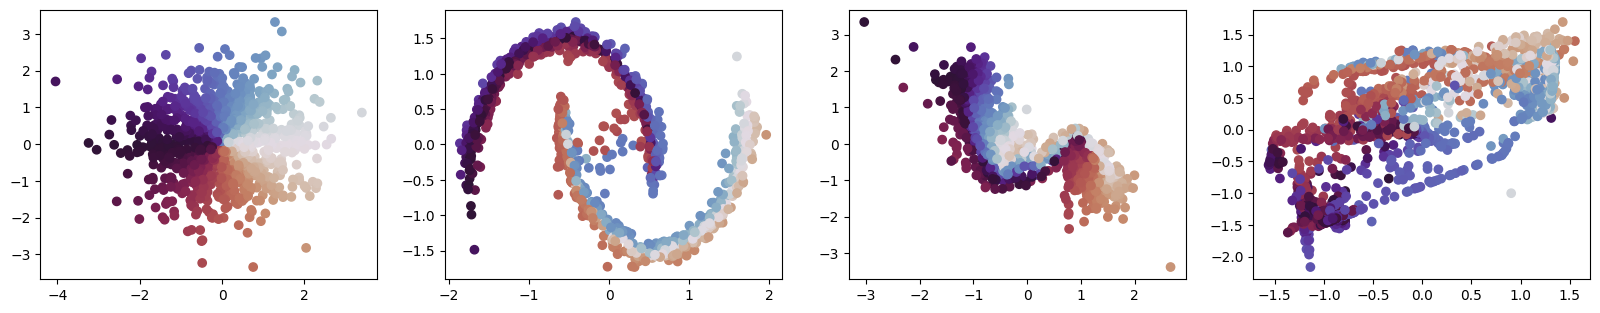

In [59]:
angles_test = np.arctan2(z_forward1[10001:11000, 1], z_forward1[10001:11000, 0])
angles_test = angles_test % (2 * np.pi)
angles_test = angles_test / (2 * np.pi)

encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11000]), torch.tensor(np.array(data_y1[10001:11000])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)

fig, axs = plt.subplots(1, 4, figsize=(20, 3.5))
axs[0].scatter(z_forward1[10001:11000, 0], z_forward1[10001:11000, 1], c=angles_test, cmap='twilight')
axs[1].scatter(data_x1[10001:11000, 0], data_x1[10001:11000, 1], c=angles_test, cmap='twilight')
axs[2].scatter(data_y1[10001:11000, 0], data_y1[10001:11000, 1], c=angles_test, cmap='twilight')
axs[3].scatter(out[:, 0], out[:, 1], c=list(angles_test) * 2, cmap='twilight')

***Луны и кольца:***

*   До обучения MAE: 1.5754285

*Без шума*
*   Contastive MAE: 0.2825636
*   DebiasedNeg MAE: 0.36
*   DebiasedPos MAE: nan

*С нормальным шумом*
*   Contastive MAE: 0.35907006
*   DebiasedNeg MAE: 0.42277724
*   DebiasedPos MAE: nan

*Есть неверные пары*
*   Contrastive MAE: 0.27958423
*   DebiasedPos MAE: 0.34718418

***Луны и 5 кругов:***

*   До обучения MAE: 1.40

*Без шума*
*   Contastive MAE: 0.27984595
*   DebiasedNeg MAE: nan
*   DebiasedPos MAE: nan

*С нормальным шумом*
*   Contastive MAE: 0.38620654

*Есть неверные позитивные пары*
*   Contrastive MAE: 0.36245066
*   DebiasedPos MAE: 0.3972798

## Луны и кольца

In [ ]:
encoder.eval()
x = torch.tensor(data_x2[10000:11000])
y = torch.tensor(np.array(data_y2[10000:11000]))
x1, y1 = encoder(x, y)

distances = np.linalg.norm((x1 - y1).detach().numpy(), axis=1)
average_distance = np.mean(distances)
print("MAE:", average_distance)
# out = torch.cat([x1, y1], dim=0).detach().numpy()
# labels = [0] * 1000 + [1] * 1000

MAE: 0.48850605


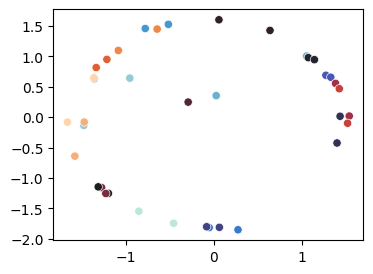

In [ ]:
encoder.eval()
x, y = encoder(torch.tensor(data_x2[10001:10020]), torch.tensor(np.array(data_y2[10001:10020])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(19)] * 2

plt.figure(figsize=(4,3))
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
plt.legend('', frameon=False)

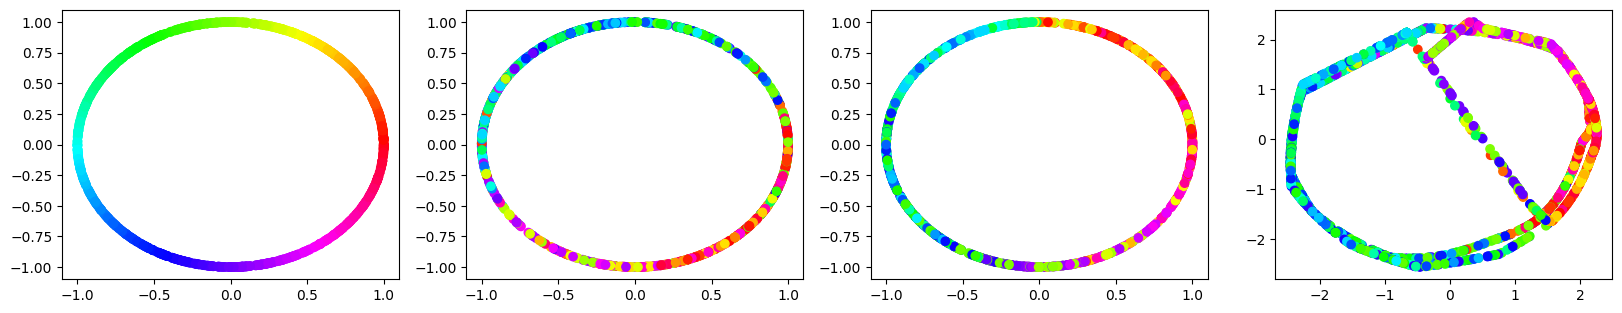

In [ ]:
angles_test = np.arctan2(z_forward1[10001:11000, 1], z_forward1[10001:11000, 0])
angles_test = angles_test % (2 * np.pi)
angles_test = angles_test / (2 * np.pi)

z_forward2 = Normalizer().fit_transform(z_forward1)

encoder.eval()
x, y = encoder(torch.tensor(data_x2[10001:11000]), torch.tensor(np.array(data_y2[10001:11000])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)

fig, axs = plt.subplots(1, 4, figsize=(20, 3.5))
axs[0].scatter(z_forward2[10001:11000, 0], z_forward2[10001:11000, 1], c=angles_test, cmap='hsv')
axs[1].scatter(data_x2[10001:11000, 0], data_x2[10001:11000, 1], c=angles_test, cmap='hsv')
axs[2].scatter(data_y2[10001:11000, 0], data_y2[10001:11000, 1], c=angles_test, cmap='hsv')
axs[3].scatter(out[:, 0], out[:, 1], c=list(angles_test) * 2, cmap='hsv')

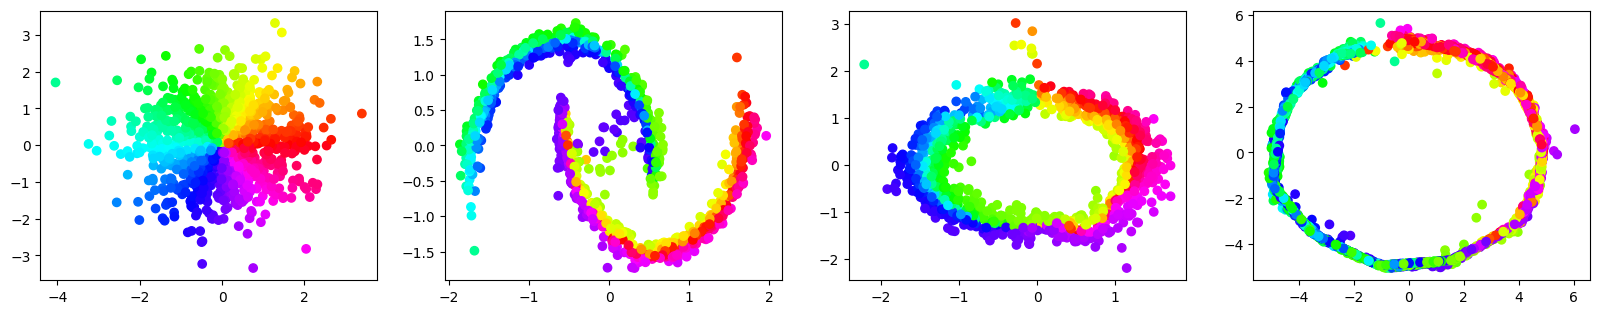

In [ ]:
angles_test = np.arctan2(z_forward1[10001:11000, 1], z_forward1[10001:11000, 0])
angles_test = angles_test % (2 * np.pi)
angles_test = angles_test / (2 * np.pi)

encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11000]), torch.tensor(np.array(data_y1[10001:11000])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)

fig, axs = plt.subplots(1, 4, figsize=(20, 3.5))
axs[0].scatter(z_forward1[10001:11000, 0], z_forward1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[1].scatter(data_x1[10001:11000, 0], data_x1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[2].scatter(data_y1[10001:11000, 0], data_y1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[3].scatter(out[:, 0], out[:, 1], c=list(angles_test) * 2, cmap='hsv')

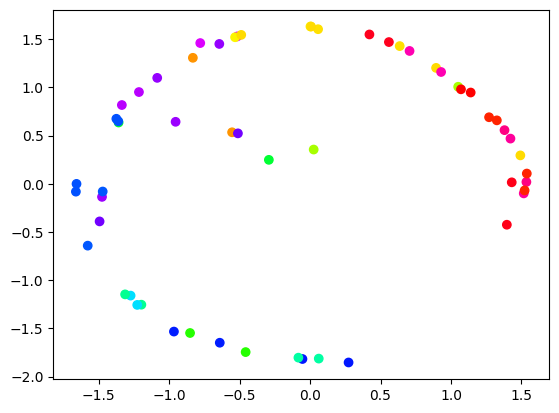

In [ ]:
encoder.eval()
x, y = encoder(torch.tensor(data_x2[10001:10030]), torch.tensor(np.array(data_y2[10001:10030])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(29)] * 2

plt.scatter(out[:, 0], out[:, 1], c=list(angles_test[:29]) * 2, cmap='hsv')

### Contrastive Loss

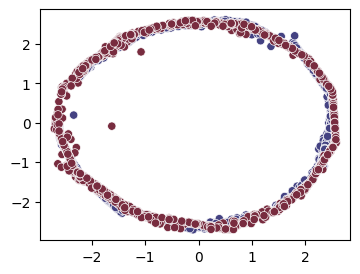

In [ ]:
encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11001]), torch.tensor(np.array(data_y[10001:11001])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(19)] * 2
labels = [0] * 1000 + [1] * 1000

plt.figure(figsize=(4,3))
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
plt.legend('', frameon=False)

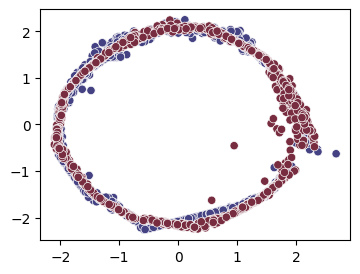

In [ ]:
# С неверными парами
encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11001]), torch.tensor(np.array(data_y1[10001:11001])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(19)] * 2
labels = [0] * 1000 + [1] * 1000

plt.figure(figsize=(4,3))
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
plt.legend('', frameon=False)

### DebiasedNeg Loss

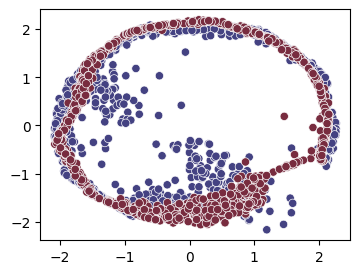

In [ ]:
# С нормальным шумом
encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11001]), torch.tensor(np.array(data_y[10001:11001])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(19)] * 2
labels = [0] * 1000 + [1] * 1000

plt.figure(figsize=(4,3))
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
plt.legend('', frameon=False)

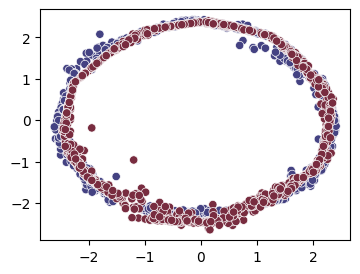

In [ ]:
# С неверными парами
encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11001]), torch.tensor(np.array(data_y1[10001:11001])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(19)] * 2
labels = [0] * 1000 + [1] * 1000

plt.figure(figsize=(4,3))
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
plt.legend('', frameon=False)

## Луны и 5 кругов, Contrastive loss

In [ ]:
encoder.eval()
x = torch.tensor(data_x1[10000:11000])
y = torch.tensor(np.array(data_y[10000:11000]))
x1, y1 = encoder(x, y)

distances = np.linalg.norm((x1 - y1).detach().numpy(), axis=1)
average_distance = np.mean(distances)
print("MAE:", average_distance)

MAE: 0.81402934


### Contrastive Loss

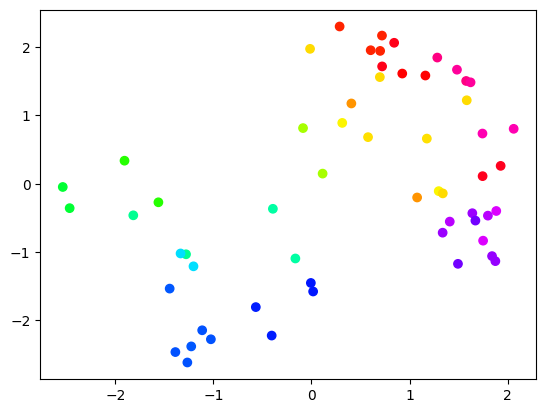

In [ ]:
encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:10030]), torch.tensor(np.array(data_y1[10001:10030])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(29)] * 2

plt.scatter(out[:, 0], out[:, 1], c=list(angles_test[:29]) * 2, cmap='hsv')

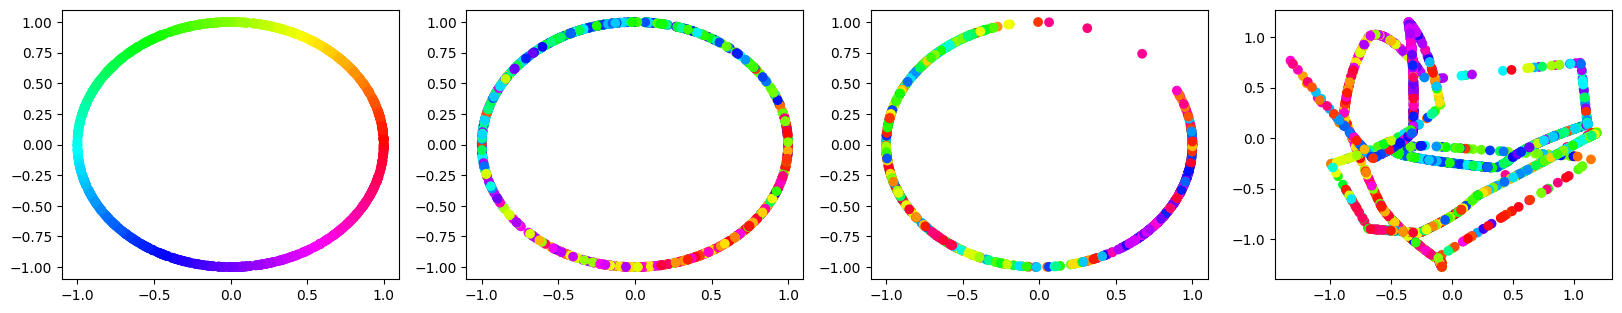

In [ ]:
angles_test = np.arctan2(z_forward1[10001:11000, 1], z_forward1[10001:11000, 0])
angles_test = angles_test % (2 * np.pi)
angles_test = angles_test / (2 * np.pi)

z_forward2 = Normalizer().fit_transform(z_forward1)

encoder.eval()
x, y = encoder(torch.tensor(data_x2[10001:11000]), torch.tensor(np.array(data_y2[10001:11000])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)

fig, axs = plt.subplots(1, 4, figsize=(20, 3.5))
axs[0].scatter(z_forward2[10001:11000, 0], z_forward2[10001:11000, 1], c=angles_test, cmap='hsv')
axs[1].scatter(data_x2[10001:11000, 0], data_x2[10001:11000, 1], c=angles_test, cmap='hsv')
axs[2].scatter(data_y2[10001:11000, 0], data_y2[10001:11000, 1], c=angles_test, cmap='hsv')
axs[3].scatter(out[:, 0], out[:, 1], c=list(angles_test) * 2, cmap='hsv')

(-5.0, 3.0)

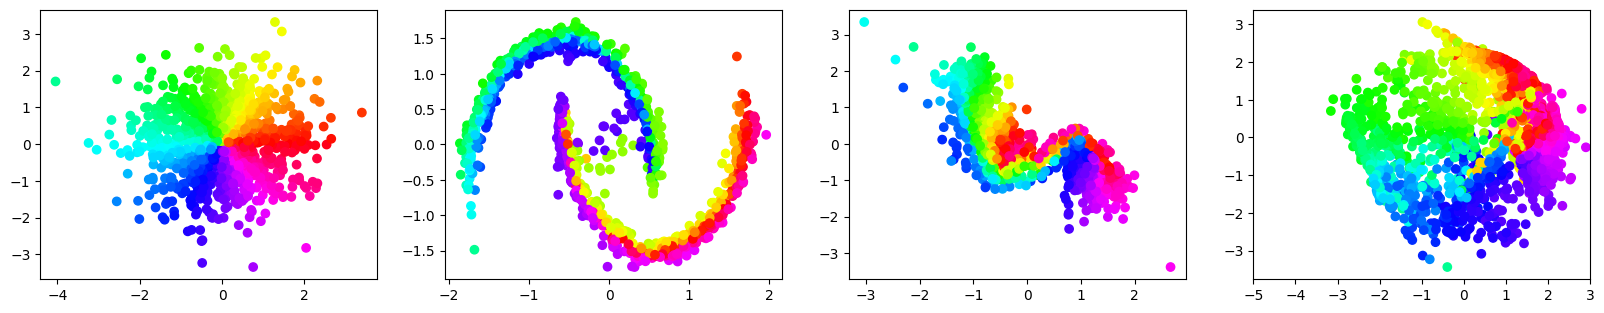

In [ ]:
angles_test = np.arctan2(z_forward1[10001:11000, 1], z_forward1[10001:11000, 0])
angles_test = angles_test % (2 * np.pi)
angles_test = angles_test / (2 * np.pi)

encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11000]), torch.tensor(np.array(data_y1[10001:11000])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)

fig, axs = plt.subplots(1, 4, figsize=(20, 3.5))
axs[0].scatter(z_forward1[10001:11000, 0], z_forward1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[1].scatter(data_x1[10001:11000, 0], data_x1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[2].scatter(data_y1[10001:11000, 0], data_y1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[3].scatter(out[:, 0], out[:, 1], c=list(angles_test) * 2, cmap='hsv')

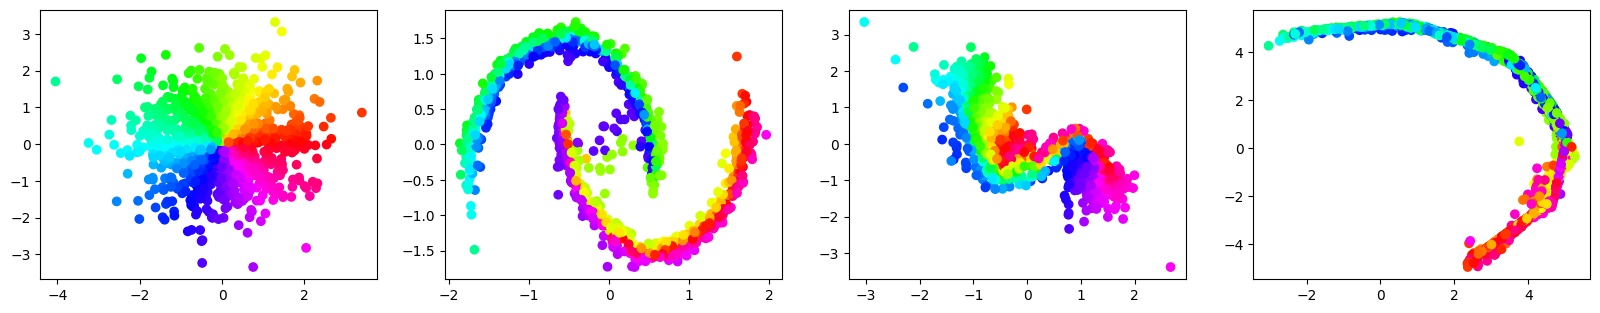

In [ ]:
angles_test = np.arctan2(z_forward1[10001:11000, 1], z_forward1[10001:11000, 0])
angles_test = angles_test % (2 * np.pi)
angles_test = angles_test / (2 * np.pi)

encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11000]), torch.tensor(np.array(data_y1[10001:11000])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)

fig, axs = plt.subplots(1, 4, figsize=(20, 3.5))
axs[0].scatter(z_forward1[10001:11000, 0], z_forward1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[1].scatter(data_x1[10001:11000, 0], data_x1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[2].scatter(data_y1[10001:11000, 0], data_y1[10001:11000, 1], c=angles_test, cmap='hsv')
axs[3].scatter(out[:, 0], out[:, 1], c=list(angles_test) * 2, cmap='hsv')

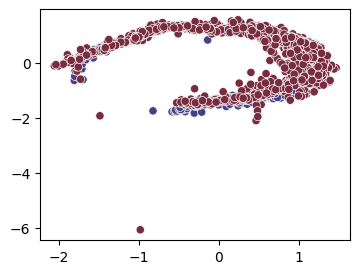

In [ ]:
encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11001]), torch.tensor(np.array(data_y[10001:11001])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(19)] * 2
labels = [0] * 1000 + [1] * 1000

plt.figure(figsize=(4,3))
plt.xlim(3, -3)
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
# plt.axis('off')
plt.legend('', frameon=False)

### DebiasedNeg Loss

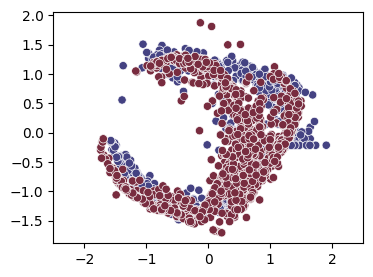

In [ ]:
encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:11001]), torch.tensor(np.array(data_y[10001:11001])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(19)] * 2
labels = [0] * 1000 + [1] * 1000

plt.figure(figsize=(4,3))
plt.xlim(-2.5, 2.5)
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
plt.legend('', frameon=False)

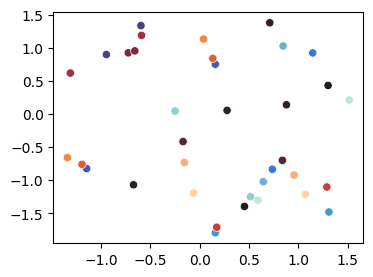

In [ ]:
out = np.concatenate([data_x1[10001:10020], data_y1[10001:10020]])
out = np.array(out)
labels = [i for i in range(19)] * 2

plt.figure(figsize=(4,3))
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
# plt.axis('off')
plt.legend('', frameon=False)

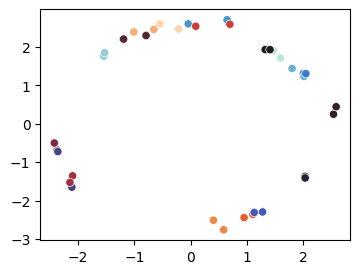

In [ ]:
encoder.eval()
x, y = encoder(torch.tensor(data_x1[10001:10020]), torch.tensor(np.array(data_y[10001:10020])))
out = torch.cat([x, y], dim=0).detach().numpy()
out = np.array(out)
labels = [i for i in range(19)] * 2

plt.figure(figsize=(4,3))
sns.scatterplot(x=out[:, 0], y=out[:, 1], hue=labels, palette="icefire")
# plt.axis('off')
plt.legend('', frameon=False)

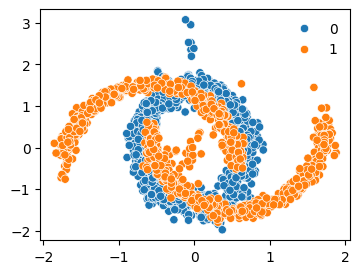

In [ ]:
plt.figure(figsize=(4,3))
sns.scatterplot(x=torch.cat([x, y], dim=0).detach().numpy()[:, 0], y=torch.cat([x, y], dim=0).detach().numpy()[:, 1], hue=labels)
# plt.axis('off')
plt.legend(frameon=False)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=2, hidden_size=10, output_size=2):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

def discriminator_loss(real_outputs, fake_outputs):
    real_loss = nn.BCELoss()(real_outputs, torch.ones_like(real_outputs))
    fake_loss = nn.BCELoss()(fake_outputs, torch.zeros_like(fake_outputs))
    total_loss = real_loss + fake_loss
    return total_loss

def train(encoder, discriminator, loss_func, data_loader, encoder_optimizer, discriminator_optimizer, batch_size):
    encoder.train()
    discriminator.train()
    normal_dist = torch.distributions.Normal(torch.tensor([0.0, 0.0]), torch.tensor([1.0, 1.0]))
    total_loss, total_num, train_bar = 0.0, 0, data_loader
    total_contrastive_loss, total_normal_x_loss, total_normal_y_loss = 0.0, 0.0, 0.0
    for pos_1, pos_2 in train_bar:
        discriminator_optimizer.zero_grad()

        x, y = encoder(pos_1, pos_2)
        x_disc, y_disc = discriminator(x), discriminator(y)
        normal_sample_x = torch.sigmoid(normal_dist.sample((x_disc.shape[0],)))
        normal_sample_y = torch.sigmoid(normal_dist.sample((x_disc.shape[0],)))
        x_disc_loss = discriminator_loss(x_disc, normal_sample_x)
        y_disc_loss = discriminator_loss(y_disc, normal_sample_y)
        disc_loss = x_disc_loss + y_disc_loss
        disc_loss.backward()
        discriminator_optimizer.step()

        x, y = encoder(pos_1, pos_2)
        x_disc, y_disc = discriminator(x), discriminator(y)

        x_norm = F.normalize(x, dim=1)
        y_norm = F.normalize(y, dim=1)

        contrastive_loss = loss_func(x_norm, y_norm)
        c_x_disc_loss = nn.BCELoss()(x_disc, torch.ones_like(x_disc))
        c_y_disc_loss = nn.BCELoss()(y_disc, torch.ones_like(y_disc))
        normal_x_loss = kl_divergence_loss(x)
        normal_y_loss = kl_divergence_loss(y)
        loss = contrastive_loss + c_x_disc_loss + c_y_disc_loss + normal_x_loss + normal_y_loss
        loss.backward()
        encoder_optimizer.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        total_contrastive_loss += contrastive_loss.item() * batch_size
        total_normal_x_loss += c_x_disc_loss.item() * batch_size
        total_normal_y_loss += c_y_disc_loss.item() * batch_size
    return total_loss / total_num, total_contrastive_loss / total_num, total_normal_x_loss / total_num, total_normal_y_loss / total_num